In [18]:
import numpy as np

# For Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# For Building TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

# Reduce Precision
np.set_printoptions(precision=2)

# Matplotlib for Plotting
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Suppress Warnings
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

## Data Preperation

In [4]:
# Load Dataset
data = np.loadtxt("data_w3_ex1.csv", delimiter=',')

# Split Dataset
x = data[:, 0]
y = data[:, 1]

# Converting 1D Arrays to 2D Arrays
x = np.expand_dims(x, axis=1)
y = np.expand_dims(y, axis=1)

# Checking the Shape
print(f"Shape of Input: {x.shape}")
print(f"Shape of Output: {y.shape}")

Shape of Input: (50, 1)
Shape of Output: (50, 1)


### Split the dataset into training, cross validation, and test sets

In previous labs, you might have used the entire dataset to train your models. In practice however, it is best to hold out a portion of your data to measure how well your model generalizes to new examples. This will let you know if the model has overfit to your training set.

As mentioned in the lecture, it is common to split your data into three parts:

* ***training set*** - used to train the model
* ***cross validation set (also called validation, development, or dev set)*** - used to evaluate the different model configurations you are choosing from. For example, you can use this to make a decision on what polynomial features to add to your dataset.
* ***test set*** - used to give a fair estimate of your chosen model's performance against new examples. This should not be used to make decisions while you are still developing the models.

Scikit-learn provides a [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to split your data into the parts mentioned above. In the code cell below, you will split the entire dataset into 60% training, 20% cross validation, and 20% test.

In [5]:
# Get 60% Training Data
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=1)

# Get 20% Cross Validation Data
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Deleting extra variables
del x_, y_

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (30, 1)
the shape of the training set (target) is: (30, 1)

the shape of the cross validation set (input) is: (10, 1)
the shape of the cross validation set (target) is: (10, 1)

the shape of the test set (input) is: (10, 1)
the shape of the test set (target) is: (10, 1)


### Feature scaling

For that, you will use the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class from scikit-learn. This computes the z-score of your inputs. As a refresher, the z-score is given by the equation:

$$ z = \frac{x - \mu}{\sigma} $$

where $\mu$ is the mean of the feature values and $\sigma$ is the standard deviation.

In [9]:
# Initialize Scaler
scaler_linear = StandardScaler()

# Fit the scaler to the training set
X_train_scaled = scaler_linear.fit_transform(x_train)

print(f"Computed mean of the training set: {scaler_linear.mean_.squeeze():.2f}")
print(f"Computed standard deviation of the training set: {scaler_linear.scale_.squeeze():.2f}")

Computed mean of the training set: 2504.06
Computed standard deviation of the training set: 574.85


### Train the Model

In [10]:
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

LinearRegression()

### Evaluate the Model

To evaluate the performance of your model, you will measure the error for the training and cross validation sets. For the training error, recall the equation for calculating the mean squared error (MSE):

$$J_{train}(\vec{w}, b) = \frac{1}{2m_{train}}\left[\sum_{i=1}^{m_{train}}(f_{\vec{w},b}(\vec{x}_{train}^{(i)}) - y_{train}^{(i)})^2\right]$$

Scikit-learn also has a built-in [`mean_squared_error()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) function that you can use. Take note though that [as per the documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error), scikit-learn's implementation only divides by `m` and not `2*m`, where `m` is the number of examples. As mentioned in Course 1 of this Specialization (cost function lectures), dividing by `2m` is a convention we will follow but the calculations should still work whether or not you include it. Thus, to match the equation above, you can use the scikit-learn function then divide by 2 as shown below. We also included a for-loop implementation so you can check that it's equal. 

In [14]:
yhat = linear_model.predict(X_train_scaled)

# Calculating MSE
print(f"Training MSE Using Scikit Learn: {mean_squared_error(y_train, yhat) / 2}")

# Using For Loop
total_squared_error = 0 

for i in range(len(yhat)):
    squared_error_i = (yhat[i] - y_train[i]) ** 2
    total_squared_error += squared_error_i
mse = total_squared_error / (2 * len(yhat))

print(f"Training MSE Using For Loop: {mse.squeeze()}")

Training MSE Using Scikit Learn: 406.19374192533155
Training MSE Using For Loop: 406.19374192533155


In [15]:
# Scale Cross Validation and Check MSE
X_cv_scaled = scaler_linear.transform(x_cv)
yhat = linear_model.predict(X_cv_scaled)

# Calculating MSE
print(f"Validation MSE: {mean_squared_error(y_cv, yhat) / 2}")

Validation MSE: 551.7789026952216


### Iterating for Models upto Degree 10

In [16]:
train_mses = []
cv_mses = []
models = []
polys = []
scalers = []

# Loop till degree 10
for degree in range(1, 11):

    # Mapping to a Polynomial Model
    poly = PolynomialFeatures(degree, include_bias=False)
    X_train_mapped = poly.fit_transform(x_train)
    polys.append(poly)

    # Applying Scaling
    scaler_poly = StandardScaler()
    X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
    scalers.append(scaler_poly)

    # Creating Model
    model = LinearRegression()
    model.fit(X_train_mapped_scaled, y_train)
    models.append(model)

    # Calculating MSE
    yhat = model.predict(X_train_mapped_scaled)
    train_mse = mean_squared_error(y_train, yhat) / 2
    train_mses.append(train_mse)

    # Applying for CV
    X_cv_mapped = poly.transform(x_cv)
    X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

    # Calculating MSE for Cross Validation
    yhat = model.predict(X_cv_mapped_scaled)
    cv_mse = mean_squared_error(y_cv, yhat) / 2
    cv_mses.append(cv_mse)

In [19]:
def plot_train_cv_mses(degrees, train_mses, cv_mses, title):
    degrees = range(1,11)
    plt.plot(degrees, train_mses, marker='o', c='r', label='training MSEs'); 
    plt.plot(degrees, cv_mses, marker='o', c='b', label='CV MSEs'); 
    plt.title(title)
    plt.xlabel("degree"); 
    plt.ylabel("MSE"); 
    plt.legend()
    plt.show()

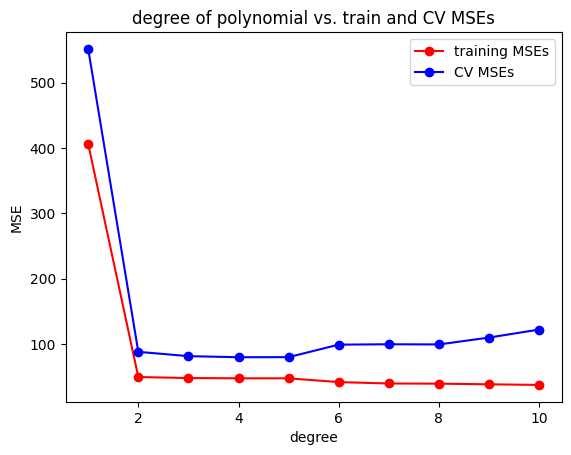

In [20]:
# Plotting Results
degrees = range(1, 11)
plot_train_cv_mses(degrees, train_mses, cv_mses, title="degree of polynomial vs. train and CV MSEs")

In [21]:
degree = np.argmin(cv_mses) + 1
print(f"Lowest CV MSE is found in the model with degree={degree}")

Lowest CV MSE is found in the model with degree=4


In [22]:
# Add polynomial features to the test set
X_test_mapped = polys[degree-1].transform(x_test)

# Scale the test set
X_test_mapped_scaled = scalers[degree-1].transform(X_test_mapped)

# Compute the test MSE
yhat = models[degree-1].predict(X_test_mapped_scaled)
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Training MSE: {train_mses[degree-1]:.2f}")
print(f"Cross Validation MSE: {cv_mses[degree-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

Training MSE: 47.15
Cross Validation MSE: 79.43
Test MSE: 104.63


## Neural Networks

In [23]:
# Add polynomial features
degree = 1
poly = PolynomialFeatures(degree, include_bias=False)
X_train_mapped = poly.fit_transform(x_train)
X_cv_mapped = poly.transform(x_cv)
X_test_mapped = poly.transform(x_test)

In [24]:
# Scale the features using the z-score
scaler = StandardScaler()
X_train_mapped_scaled = scaler.fit_transform(X_train_mapped)
X_cv_mapped_scaled = scaler.transform(X_cv_mapped)
X_test_mapped_scaled = scaler.transform(X_test_mapped)

### Build and train the models


In [25]:
def build_models():
    
    tf.random.set_seed(20)
    
    model_1 = Sequential(
        [
            Dense(25, activation = 'relu'),
            Dense(15, activation = 'relu'),
            Dense(1, activation = 'linear')
        ],
        name='model_1'
    )

    model_2 = Sequential(
        [
            Dense(20, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(20, activation = 'relu'),
            Dense(1, activation = 'linear')
        ],
        name='model_2'
    )

    model_3 = Sequential(
        [
            Dense(32, activation = 'relu'),
            Dense(16, activation = 'relu'),
            Dense(8, activation = 'relu'),
            Dense(4, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(1, activation = 'linear')
        ],
        name='model_3'
    )
    
    model_list = [model_1, model_2, model_3]
    
    return model_list

In [26]:
nn_models = build_models()

In [30]:
# Training Models
nn_train_mses = []
nn_cv_mses = []

# Looping over the Models
for model in nn_models:

    # Compile Model
    model.compile(
        loss = 'mse',
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
    )

    print(f"Training Model: {model.name}")

    # Train the Model
    model.fit(
        X_train_mapped_scaled, y_train,
        epochs = 300,
        verbose = 0
    )

    print("Done\n")

    # Recording Training MSE
    yhat = model.predict(X_train_mapped_scaled)
    train_mse = mean_squared_error(y_train, yhat) / 2
    nn_train_mses.append(train_mse)

    # Recording Cross MSE
    yhat = model.predict(X_cv_mapped_scaled)
    cv_mse = mean_squared_error(y_cv, yhat) / 2
    nn_cv_mses.append(cv_mse)

Training Model: model_1


Done

1/1 [==============================] - 0s 120ms/step
Training Model: model_2
Done

1/1 [==============================] - 0s 227ms/step
Training Model: model_3
Done

1/1 [==============================] - 0s 141ms/step


In [31]:
# Printing Results
print("Results")
for model_num in range(len(nn_train_mses)):
    print(f"Model {model_num+1}: Training MSE: {nn_train_mses[model_num]:.2f}, " + 
          f"CV MSE: {nn_cv_mses[model_num]:.2f}")

Results
Model 1: Training MSE: 75.39, CV MSE: 98.90
Model 2: Training MSE: 406.19, CV MSE: 551.78
Model 3: Training MSE: 69.38, CV MSE: 85.63


In [32]:
# Select the model with the lowest CV MSE
model_num = 3

# Compute the test MSE
yhat = nn_models[model_num-1].predict(X_test_mapped_scaled)
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Selected Model: {model_num}")
print(f"Training MSE: {nn_train_mses[model_num-1]:.2f}")
print(f"Cross Validation MSE: {nn_cv_mses[model_num-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

1/1 [==============================] - 0s 135ms/step
Selected Model: 3
Training MSE: 69.38
Cross Validation MSE: 85.63
Test MSE: 95.86


# Classification

In [33]:
data = np.loadtxt("data_w3_ex2.csv", delimiter=',')

# Split the Data
x_bc = data[:, :-1]
y_bc = data[:, -1]

# Converting y to 2D Array
y_bc = np.expand_dims(y_bc, axis=1)

print(f"The shape of the inputs x is: {x_bc.shape}")
print(f"The shape of the targets y is: {y_bc.shape}")

The shape of the inputs x is: (200, 2)
The shape of the targets y is: (200, 1)


In [38]:
# Splitting the Dataset into Training, CV and Test Set
x_bc_train, x_, y_bc_train, y_ = train_test_split(x_bc, y_bc, test_size=0.40, random_state=1)
x_bc_cv, x_bc_test, y_bc_cv, y_bc_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

del x_, y_

In [39]:
print(f"the shape of the training set (input) is: {x_bc_train.shape}")
print(f"the shape of the training set (target) is: {y_bc_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_bc_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_bc_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_bc_test.shape}")
print(f"the shape of the test set (target) is: {y_bc_test.shape}")

the shape of the training set (input) is: (120, 2)
the shape of the training set (target) is: (120, 1)

the shape of the cross validation set (input) is: (40, 2)
the shape of the cross validation set (target) is: (40, 1)

the shape of the test set (input) is: (40, 2)
the shape of the test set (target) is: (40, 1)


In [40]:
# Scaling Features
scaler_linear = StandardScaler()

x_bc_train_scaled = scaler_linear.fit_transform(x_bc_train)
x_bc_cv_scaled = scaler_linear.transform(x_bc_cv)
x_bc_test_scaled = scaler_linear.transform(x_bc_test)

In [41]:
# Evaluating Errors for Classification
# Sample model output
probabilities = np.array([0.2, 0.6, 0.7, 0.3, 0.8])

# Apply a threshold to the model output. If greater than 0.5, set to 1. Else 0.
predictions = np.where(probabilities >= 0.5, 1, 0)

# Ground truth labels
ground_truth = np.array([1, 1, 1, 1, 1])

# Initialize counter for misclassified data
misclassified = 0

# Get number of predictions
num_predictions = len(predictions)

# Loop over each prediction
for i in range(num_predictions):
    
    # Check if it matches the ground truth
    if predictions[i] != ground_truth[i]:
        
        # Add one to the counter if the prediction is wrong
        misclassified += 1

# Compute the fraction of the data that the model misclassified
fraction_error = misclassified/num_predictions

print(f"probabilities: {probabilities}")
print(f"predictions with threshold=0.5: {predictions}")
print(f"targets: {ground_truth}")
print(f"fraction of misclassified data (for-loop): {fraction_error}")
print(f"fraction of misclassified data (with np.mean()): {np.mean(predictions != ground_truth)}")

probabilities: [0.2 0.6 0.7 0.3 0.8]
predictions with threshold=0.5: [0 1 1 0 1]
targets: [1 1 1 1 1]
fraction of misclassified data (for-loop): 0.4
fraction of misclassified data (with np.mean()): 0.4


### Build and Train Model

In [42]:
models_bc = build_models()

In [43]:
# Training
nn_train_error = []
nn_cv_error = []

for model in models_bc:
    
    # Compile Model
    model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    )

    print(f"Training Model: {model.name}")

    # Train the Model
    model.fit(
        x_bc_train_scaled, y_bc_train,
                epochs = 300,
                verbose = 0
    )

    print("Done\n")

    # Set Threshold
    threshold = 0.5

    # Record Fraction of Misclassified Examples in Training Set
    yhat = model.predict(x_bc_train_scaled)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    train_error = np.mean(yhat != y_bc_train)
    nn_train_error.append(train_error)

    # Record Fraction of Misclassified Examples in Cross Validation Set
    yhat = model.predict(x_bc_cv_scaled)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    cv_error = np.mean(yhat!= y_bc_cv)
    nn_cv_error.append(cv_error)

Training Model: model_1
Done

2/2 [==============================] - 0s 12ms/step
Training Model: model_2
Done

2/2 [==============================] - 0s 8ms/step
Training Model: model_3
Done

2/2 [==============================] - 0s 6ms/step


In [44]:
# Print the result
for model_num in range(len(nn_train_error)):
    print(
        f"Model {model_num+1}: Training Set Classification Error: {nn_train_error[model_num]:.5f}, " +
        f"CV Set Classification Error: {nn_cv_error[model_num]:.5f}"
        )

Model 1: Training Set Classification Error: 0.05000, CV Set Classification Error: 0.15000
Model 2: Training Set Classification Error: 0.03333, CV Set Classification Error: 0.17500
Model 3: Training Set Classification Error: 0.08333, CV Set Classification Error: 0.20000


In [45]:
# Select the model with the lowest error
model_num = 3

# Compute the test error
yhat = models_bc[model_num-1].predict(x_bc_test_scaled)
yhat = tf.math.sigmoid(yhat)
yhat = np.where(yhat >= threshold, 1, 0)
nn_test_error = np.mean(yhat != y_bc_test)

print(f"Selected Model: {model_num}")
print(f"Training Set Classification Error: {nn_train_error[model_num-1]:.4f}")
print(f"CV Set Classification Error: {nn_cv_error[model_num-1]:.4f}")
print(f"Test Set Classification Error: {nn_test_error:.4f}")

2/2 [==============================] - 0s 11ms/step
Selected Model: 3
Training Set Classification Error: 0.0833
CV Set Classification Error: 0.2000
Test Set Classification Error: 0.1250
